In [7]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [8]:
import os
os.getcwd()

'c:\\GitHub\\2024DriveBase\\src\\main\\java\\frc\\robot\\utils'

['x', 'y', 'heading', 'dx', 'dy', 'dtheta']
[('x', 'dx'), ('y', 'dy'), ('heading', 'dtheta')]


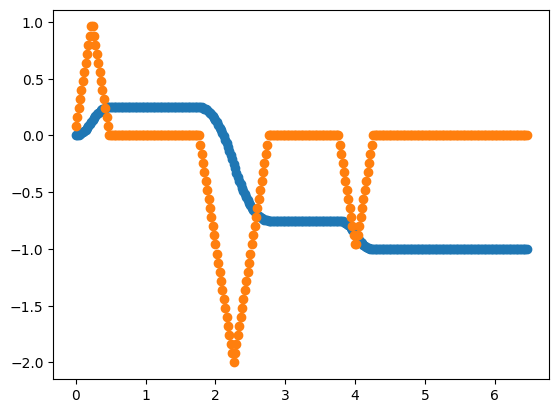

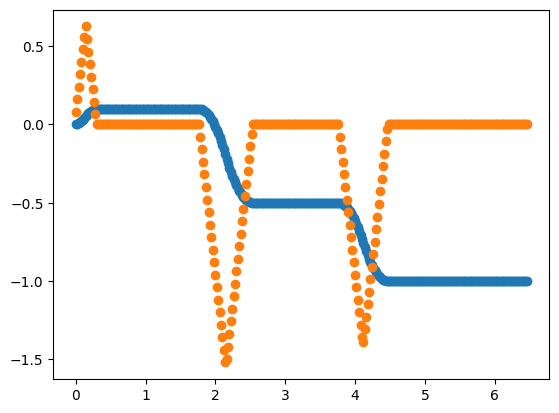

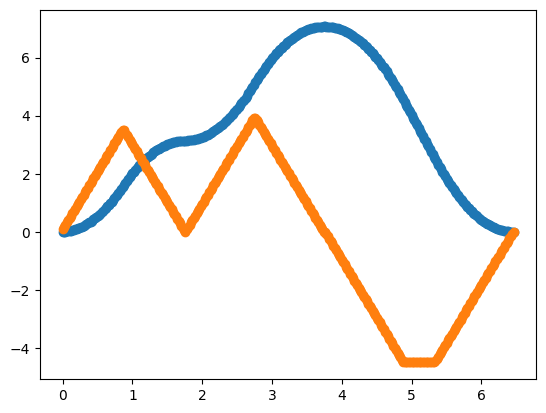

In [34]:
data = {}
headings = []
# lol plz tell me there's a better way to write that path...
with open('../../../../../../data/trajectory.csv' ,'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if i == 0:
            line = line.strip()
            line = line.split(',')
            for heading in line:
                headings.append(heading[1:-1]) # [1:-1] removes the quotes
                data[heading[1:-1]] = []
            continue
            
        line = line.strip()
        line = line.split(',')
        for i, value in enumerate(line):
            data[headings[i]].append(float(value[1:-1])) # [1:-1] removes the quotes

print(headings)
paired_headings = [(headings[i], headings[i+int(len(headings)/2)]) for i in range(0, int(len(headings) / 2))]
print(paired_headings)

dt = 0.02
data['time'] = [i * dt for i in range(len(data['x']))]

for pair in paired_headings:
    plt.plot(data['time'], data[pair[0]], 'o')
    plt.plot(data['time'], data[pair[1]], 'o')
    plt.show()